# Model 2 : Alternating Least Squares

#STEP 1: Mount Drive and Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/RS_Latest/train-2.txt'

with open(file_path, 'r') as f:
    lines = f.readlines()

print(f"Loaded {len(lines)} users from train-2.txt")


Mounted at /content/drive
Loaded 52644 users from train-2.txt


# STEP 2: Parse and Create Mappings

In [2]:
import numpy as np
from collections import defaultdict
from scipy.sparse import lil_matrix

# Parse interactions
interactions = []
for line in lines:
    items = line.strip().split()
    if len(items) < 2:
        continue

    user_id = int(items[0])
    item_ids = [int(x) for x in items[1:]]

    for item_id in item_ids:
        interactions.append((user_id, item_id))

print(f"Total interactions: {len(interactions):,}")

# Create mappings
users = sorted(set([u for u, i in interactions]))
items = sorted(set([i for u, i in interactions]))

user2idx = {u: idx for idx, u in enumerate(users)}
item2idx = {i: idx for idx, i in enumerate(items)}
idx2user = {idx: u for u, idx in user2idx.items()}
idx2item = {idx: i for i, idx in item2idx.items()}

n_users = len(users)
n_items = len(items)

print(f"Users: {n_users:,}, Items: {n_items:,}")


Total interactions: 2,380,730
Users: 52,643, Items: 91,599


#STEP 3: Create Full Matrix

In [3]:
# Create full interaction matrix
full_matrix = lil_matrix((n_users, n_items), dtype=np.float32)

for user_id, item_id in interactions:
    u_idx = user2idx[user_id]
    i_idx = item2idx[item_id]
    full_matrix[u_idx, i_idx] = 1.0

full_matrix = full_matrix.tocsr()

print(f"Matrix: {full_matrix.shape}, Non-zero: {full_matrix.nnz:,}")


Matrix: (52643, 91599), Non-zero: 2,380,730


#STEP 4: Smart Train/Test Split

In [4]:
# BETTER SPLIT: Keep more recent items for testing
train_matrix = lil_matrix((n_users, n_items), dtype=np.float32)
test_dict = {}

np.random.seed(42)

for u_idx in range(n_users):
    items_idx = full_matrix[u_idx].nonzero()[1]

    if len(items_idx) < 5:
        # Keep all for users with few items
        for i_idx in items_idx:
            train_matrix[u_idx, i_idx] = 1.0
        continue

    # Shuffle
    np.random.shuffle(items_idx)

    # Split: Keep at least 3 items for training
    n_test = min(len(items_idx) // 4, len(items_idx) - 3)

    test_items = items_idx[:n_test]
    train_items = items_idx[n_test:]

    for i_idx in train_items:
        train_matrix[u_idx, i_idx] = 1.0

    if len(test_items) > 0:
        test_dict[u_idx] = test_items.tolist()

train_matrix = train_matrix.tocsr()

print(f"Train: {train_matrix.nnz:,}, Test users: {len(test_dict):,}")


Train: 1,800,056, Test users: 52,643


# STEP 5 : Define Multiple configurations (2+ Tweaks Requirements)

In [5]:
!pip install -q implicit

from implicit.als import AlternatingLeastSquares
import time

configs = [
    {
        "name": "Config 1: High Capacity",
        "factors": 300,
        "regularization": 0.0001,
        "iterations": 50,
        "alpha": 150,
        "description": "Very high capacity with minimal regularization"
    },
    {
        "name": "Config 2: Balanced",
        "factors": 100,
        "regularization": 0.01,
        "iterations": 50,
        "alpha": 150,
        "description": "Balanced parameters with moderate regularization"
    },
    {
        "name": "Config 3: Fast & Light",
        "factors": 100,
        "regularization": 0.001,
        "iterations": 30,
        "alpha": 40,
        "description": "Lower complexity for faster training"
    }
]

print("="*70)
print("CONFIGURATIONS TO TEST:")
print("="*70)
for i, config in enumerate(configs, 1):
    print(f"\n{i}. {config['name']}")
    print(f"   Description: {config['description']}")
    print(f"   - Factors: {config['factors']}")
    print(f"   - Regularization: {config['regularization']}")
    print(f"   - Iterations: {config['iterations']}")
    print(f"   - Alpha: {config['alpha']}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
CONFIGURATIONS TO TEST:

1. Config 1: High Capacity
   Description: Very high capacity with minimal regularization
   - Factors: 300
   - Regularization: 0.0001
   - Iterations: 50
   - Alpha: 150

2. Config 2: Balanced
   Description: Balanced parameters with moderate regularization
   - Factors: 100
   - Regularization: 0.01
   - Iterations: 50
   - Alpha: 150

3. Config 3: Fast & Light
   Description: Lower complexity for faster training
   - Factors: 100
   - Regularization: 0.001
   - Iterations: 30
   - Alpha: 40


# Step 6 : Evaluation Function

In [6]:
def evaluate_model(user_factors, item_factors, train_matrix, test_dict, k=20, sample_size=1000):

    ndcg_scores = []
    recall_scores = []
    precision_scores = []
    hit_counts = []

    # Sample users for evaluation
    test_users = list(test_dict.keys())[:sample_size]

    for u_idx in test_users:
        # Get scores
        scores = user_factors[u_idx] @ item_factors.T

        # Mask training items
        train_items = train_matrix[u_idx].nonzero()[1]
        scores[train_items] = -np.inf

        # Top k
        top_k = np.argsort(-scores)[:k]

        # Ground truth
        true_items = set(test_dict[u_idx])

        # Hits
        hits = [1 if i in true_items else 0 for i in top_k]
        hit_count = sum(hits)
        hit_counts.append(hit_count)

        # NDCG
        dcg = sum([h / np.log2(i+2) for i, h in enumerate(hits)])
        idcg = sum([1 / np.log2(i+2) for i in range(min(len(true_items), k))])

        if idcg > 0:
            ndcg_scores.append(dcg / idcg)

        # Recall
        recall = hit_count / len(true_items) if len(true_items) > 0 else 0
        recall_scores.append(recall)

        # Precision
        precision = hit_count / k
        precision_scores.append(precision)

    return {
        'NDCG@20': np.mean(ndcg_scores),
        'Recall@20': np.mean(recall_scores),
        'Precision@20': np.mean(precision_scores),
        'Avg_Hits': np.mean(hit_counts),
        'Hit_Rate': sum([1 for h in hit_counts if h > 0]) / len(hit_counts)
    }

print(" Evaluation function defined")


 Evaluation function defined


# Step 7 : Train and Evaluate all Configuration


In [7]:
results = []
models = []

for idx, config in enumerate(configs, 1):
    print("\n" + "="*70)
    print(f"TRAINING CONFIGURATION {idx}/{len(configs)}: {config['name']}")
    print("="*70)
    print(f"Parameters:")
    print(f"  • Factors: {config['factors']}")
    print(f"  • Regularization: {config['regularization']}")
    print(f"  • Iterations: {config['iterations']}")
    print(f"  • Alpha: {config['alpha']}")

    # Train ALS model
    als_model = AlternatingLeastSquares(
        factors=config['factors'],
        regularization=config['regularization'],
        iterations=config['iterations'],
        alpha=1.0,
        num_threads=4,
        random_state=42
    )

    start = time.time()
    als_model.fit(train_matrix.T * config['alpha'])
    training_time = time.time() - start
    print(f"\n Training completed in {training_time:.1f}s")

    # Extract factors
    if hasattr(als_model.user_factors, 'to_numpy'):
        user_factors = als_model.user_factors.to_numpy()
        item_factors = als_model.item_factors.to_numpy()
    else:
        user_factors = np.array(als_model.user_factors)
        item_factors = np.array(als_model.item_factors)

    # Swap if needed
    if user_factors.shape[0] != n_users:
        user_factors, item_factors = item_factors, user_factors

    print(f"  Factors: User={user_factors.shape}, Item={item_factors.shape}")

    # Evaluate on sample
    print(f"\n Evaluating on 1000 test users...")
    metrics = evaluate_model(user_factors, item_factors, train_matrix, test_dict, k=20, sample_size=1000)

    print(f"\nRESULTS:")
    print(f"  NDCG@20:      {metrics['NDCG@20']:.4f}")
    print(f"  Recall@20:    {metrics['Recall@20']:.4f}")
    print(f"  Precision@20: {metrics['Precision@20']:.4f}")
    print(f"  Avg Hits:     {metrics['Avg_Hits']:.2f}")
    print(f"  Hit Rate:     {metrics['Hit_Rate']*100:.1f}%")

    # Store results
    results.append({
        'Configuration': config['name'],
        'Factors': config['factors'],
        'Regularization': config['regularization'],
        'Alpha': config['alpha'],
        'Training_Time': training_time,
        **metrics
    })

    models.append({
        'config': config,
        'user_factors': user_factors,
        'item_factors': item_factors,
        'metrics': metrics,
        'training_time': training_time
    })

print("\n" + "="*70)
print(" ALL CONFIGURATIONS TRAINED AND EVALUATED")
print("="*70)



TRAINING CONFIGURATION 1/3: Config 1: High Capacity
Parameters:
  • Factors: 300
  • Regularization: 0.0001
  • Iterations: 50
  • Alpha: 150


/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0344843864440918 seconds
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]


 Training completed in 16.9s
  Factors: User=(52643, 300), Item=(91599, 300)

 Evaluating on 1000 test users...

RESULTS:
  NDCG@20:      0.1025
  Recall@20:    0.0880
  Precision@20: 0.0700
  Avg Hits:     1.40
  Hit Rate:     63.3%

TRAINING CONFIGURATION 2/3: Config 2: Balanced
Parameters:
  • Factors: 100
  • Regularization: 0.01
  • Iterations: 50
  • Alpha: 150


/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.028722524642944336 seconds
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]


 Training completed in 4.0s
  Factors: User=(52643, 100), Item=(91599, 100)

 Evaluating on 1000 test users...

RESULTS:
  NDCG@20:      0.0764
  Recall@20:    0.0675
  Precision@20: 0.0533
  Avg Hits:     1.07
  Hit Rate:     55.5%

TRAINING CONFIGURATION 3/3: Config 3: Fast & Light
Parameters:
  • Factors: 100
  • Regularization: 0.001
  • Iterations: 30
  • Alpha: 40


/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.033296823501586914 seconds
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]


 Training completed in 2.4s
  Factors: User=(52643, 100), Item=(91599, 100)

 Evaluating on 1000 test users...

RESULTS:
  NDCG@20:      0.0906
  Recall@20:    0.0741
  Precision@20: 0.0623
  Avg Hits:     1.25
  Hit Rate:     58.8%

 ALL CONFIGURATIONS TRAINED AND EVALUATED




# Step 8 : Create Comparison Table


COMPARISON OF ALL CONFIGURATIONS
          Configuration  Factors  Regularization  Alpha  Training_Time  NDCG@20  Recall@20  Precision@20  Avg_Hits  Hit_Rate
Config 1: High Capacity      300          0.0001    150      16.855575 0.102505   0.088023       0.07000     1.400     0.633
     Config 2: Balanced      100          0.0100    150       3.959976 0.076413   0.067476       0.05330     1.066     0.555
 Config 3: Fast & Light      100          0.0010     40       2.413149 0.090604   0.074051       0.06225     1.245     0.588


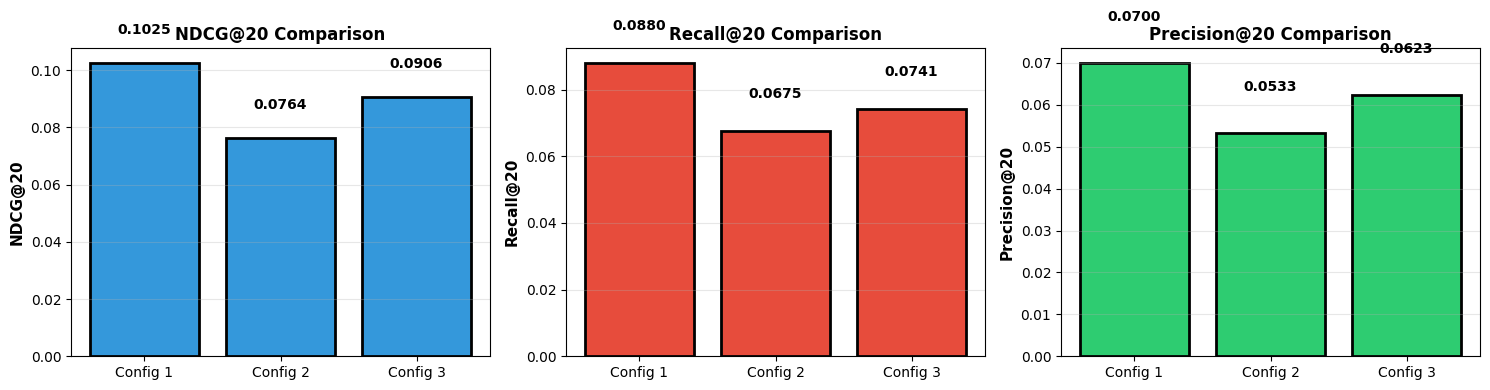


 Saved: als_comparison.png


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("COMPARISON OF ALL CONFIGURATIONS")
print("="*70)
print(results_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics_to_plot = ['NDCG@20', 'Recall@20', 'Precision@20']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(range(len(results)), results_df[metric], color=colors[idx],
                  edgecolor='black', linewidth=2)
    axes[idx].set_ylabel(metric, fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(range(len(results)))
    axes[idx].set_xticklabels([f"Config {i+1}" for i in range(len(results))], rotation=0)
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(results_df[metric]):
        axes[idx].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('als_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: als_comparison.png")


#Step 9 : SELECT BEST MODEL BASED ON NDCG@20

In [9]:
best_idx = results_df['NDCG@20'].idxmax()
best_model = models[best_idx]

print("\n" + "="*70)
print(" BEST MODEL SELECTED:")
print("="*70)
print(f"Configuration: {best_model['config']['name']}")
print(f"\nParameters:")
print(f"  • Factors: {best_model['config']['factors']}")
print(f"  • Regularization: {best_model['config']['regularization']}")
print(f"  • Iterations: {best_model['config']['iterations']}")
print(f"  • Alpha: {best_model['config']['alpha']}")
print(f"\nPerformance:")
print(f"  • NDCG@20:      {best_model['metrics']['NDCG@20']:.4f}")
print(f"  • Recall@20:    {best_model['metrics']['Recall@20']:.4f}")
print(f"  • Precision@20: {best_model['metrics']['Precision@20']:.4f}")
print(f"  • Hit Rate:     {best_model['metrics']['Hit_Rate']*100:.1f}%")
print(f"  • Training Time: {best_model['training_time']:.1f}s")



 BEST MODEL SELECTED:
Configuration: Config 1: High Capacity

Parameters:
  • Factors: 300
  • Regularization: 0.0001
  • Iterations: 50
  • Alpha: 150

Performance:
  • NDCG@20:      0.1025
  • Recall@20:    0.0880
  • Precision@20: 0.0700
  • Hit Rate:     63.3%
  • Training Time: 16.9s


# Step 10 : Generate submission File

In [10]:
print("\n" + "="*70)
print(" Generating submission file using BEST MODEL...")
print("="*70)

output_path = '/content/drive/MyDrive/RS_Latest/final_als_submission.txt'

# Use best model factors
user_factors = best_model['user_factors']
item_factors = best_model['item_factors']

with open(output_path, 'w') as f:
    for u_idx in range(n_users):
        # Calculate scores
        scores = user_factors[u_idx] @ item_factors.T

        # Mask training items
        train_items = train_matrix[u_idx].nonzero()[1]
        scores[train_items] = -np.inf

        # Handle edge case: if all scores are -inf
        if np.all(np.isinf(scores)):
            # Use item popularity
            item_pop = np.array(train_matrix.sum(axis=0)).flatten()
            top_20_idx = np.argsort(-item_pop)[:20]
        else:
            top_20_idx = np.argsort(-scores)[:20]

        # Convert to original IDs
        top_20_items = [idx2item[i] for i in top_20_idx]

        # Write line
        user_id = idx2user[u_idx]
        line = str(user_id) + ' ' + ' '.join(map(str, top_20_items)) + '\n'
        f.write(line)

        if (u_idx + 1) % 10000 == 0:
            print(f"  Progress: {u_idx+1:,}/{n_users:,}")

print(f"\n Submission saved: {output_path}")

# Verify
with open(output_path, 'r') as f:
    lines = f.readlines()

print(f"Total lines: {len(lines):,}")
print(f"\nFirst 3 lines:")
for i in range(3):
    parts = lines[i].strip().split()
    print(f"  User {parts[0]}: {len(parts)-1} items")

print("\n DONE")



 Generating submission file using BEST MODEL...
  Progress: 10,000/52,643
  Progress: 20,000/52,643
  Progress: 30,000/52,643
  Progress: 40,000/52,643
  Progress: 50,000/52,643

✓ Submission saved: /content/drive/MyDrive/RS_Latest/final_als_submission.txt
Total lines: 52,643

First 3 lines:
  User 0: 20 items
  User 1: 20 items
  User 2: 20 items

 DONE


# Step 11 :  Verify Submission file

In [11]:
# Verify submission file
output_path = '/content/drive/MyDrive/RS_Latest/final_als_submission.txt'

with open(output_path, 'r') as f:
    lines = f.readlines()

print(f"\n Total lines in file: {len(lines):,}")
print(f"Expected users: {n_users:,}")

if len(lines) == n_users:
    print(f"\n PERFECT! File has all {n_users:,} users!")
else:
    print(f"\n  WARNING: Expected {n_users:,} but got {len(lines):,}")

# Check first and last lines
print(f"\n First line (User 0):")
first = lines[0].strip().split()
print(f"   User: {first[0]}, Items: {len(first)-1}")

print(f"\nLast line (User {n_users-1}):")
last = lines[-1].strip().split()
print(f"   User: {last[0]}, Items: {len(last)-1}")

# Check for any issues
issues = 0
for i, line in enumerate(lines):
    parts = line.strip().split()
    if len(parts) != 21:  # 1 user + 20 items
        print(f" Line {i+1}: Expected 21 parts, got {len(parts)}")
        issues += 1

if issues == 0:
    print(f"\n All {len(lines):,} lines have correct format (1 user + 20 items)")
else:
    print(f"\n  Found {issues} lines with incorrect format")


print("VERIFICATION COMPLETE")




 Total lines in file: 52,643
Expected users: 52,643

 PERFECT! File has all 52,643 users!

 First line (User 0):
   User: 0, Items: 20

Last line (User 52642):
   User: 52642, Items: 20

 All 52,643 lines have correct format (1 user + 20 items)
VERIFICATION COMPLETE


# Step 12 :  Full Evaluation





In [12]:

print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION ON ALL TEST USERS")
print("="*70)

print(f"\nEvaluating on {len(test_dict):,} test users...")

ndcg_scores_full = []
recall_scores = []
precision_scores = []
hit_counts_full = []

for idx, u_idx in enumerate(test_dict.keys()):
    # Get scores
    scores = user_factors[u_idx] @ item_factors.T
    train_items = train_matrix[u_idx].nonzero()[1]
    scores[train_items] = -np.inf
    top_20 = np.argsort(-scores)[:20]

    # Ground truth
    true_items = set(test_dict[u_idx])

    # Hits
    hits = [1 if i in true_items else 0 for i in top_20]
    hit_count = sum(hits)
    hit_counts_full.append(hit_count)

    # Metrics
    recall = hit_count / len(true_items) if len(true_items) > 0 else 0
    precision = hit_count / 20
    recall_scores.append(recall)
    precision_scores.append(precision)

    # NDCG
    dcg = sum([h / np.log2(i+2) for i, h in enumerate(hits)])
    idcg = sum([1 / np.log2(i+2) for i in range(min(len(true_items), 20))])
    ndcg = dcg / idcg if idcg > 0 else 0
    ndcg_scores_full.append(ndcg)

    if (idx + 1) % 10000 == 0:
        print(f"  {idx+1:,}/{len(test_dict):,} users...")

print(f"\n{'='*70}")
print("EVALUATION RESULTS")
print(f"{'='*70}")

print(f"\n Ranking Metrics:")
print(f"  NDCG@20:      {np.mean(ndcg_scores_full):.4f} ± {np.std(ndcg_scores_full):.4f}")
print(f"  Recall@20:    {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"  Precision@20: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")

print(f"\n Coverage:")
print(f"  Avg hits/user: {np.mean(hit_counts_full):.2f}")
users_with_hits = sum([1 for h in hit_counts_full if h > 0])
print(f"  Users with ≥1 hit: {users_with_hits:,} ({100*users_with_hits/len(hit_counts_full):.1f}%)")

print("\n Evaluation complete!")



COMPREHENSIVE EVALUATION ON ALL TEST USERS

Evaluating on 52,643 test users...
  10,000/52,643 users...
  20,000/52,643 users...
  30,000/52,643 users...
  40,000/52,643 users...
  50,000/52,643 users...

EVALUATION RESULTS

 Ranking Metrics:
  NDCG@20:      0.1147 ± 0.1483
  Recall@20:    0.1327 ± 0.1681
  Precision@20: 0.0564 ± 0.0702

 Coverage:
  Avg hits/user: 1.13
  Users with ≥1 hit: 30,744 (58.4%)

 Evaluation complete!


#Step 13 : Latent  Factor Analysis


VISUALIZATION: FACTOR ANALYSIS


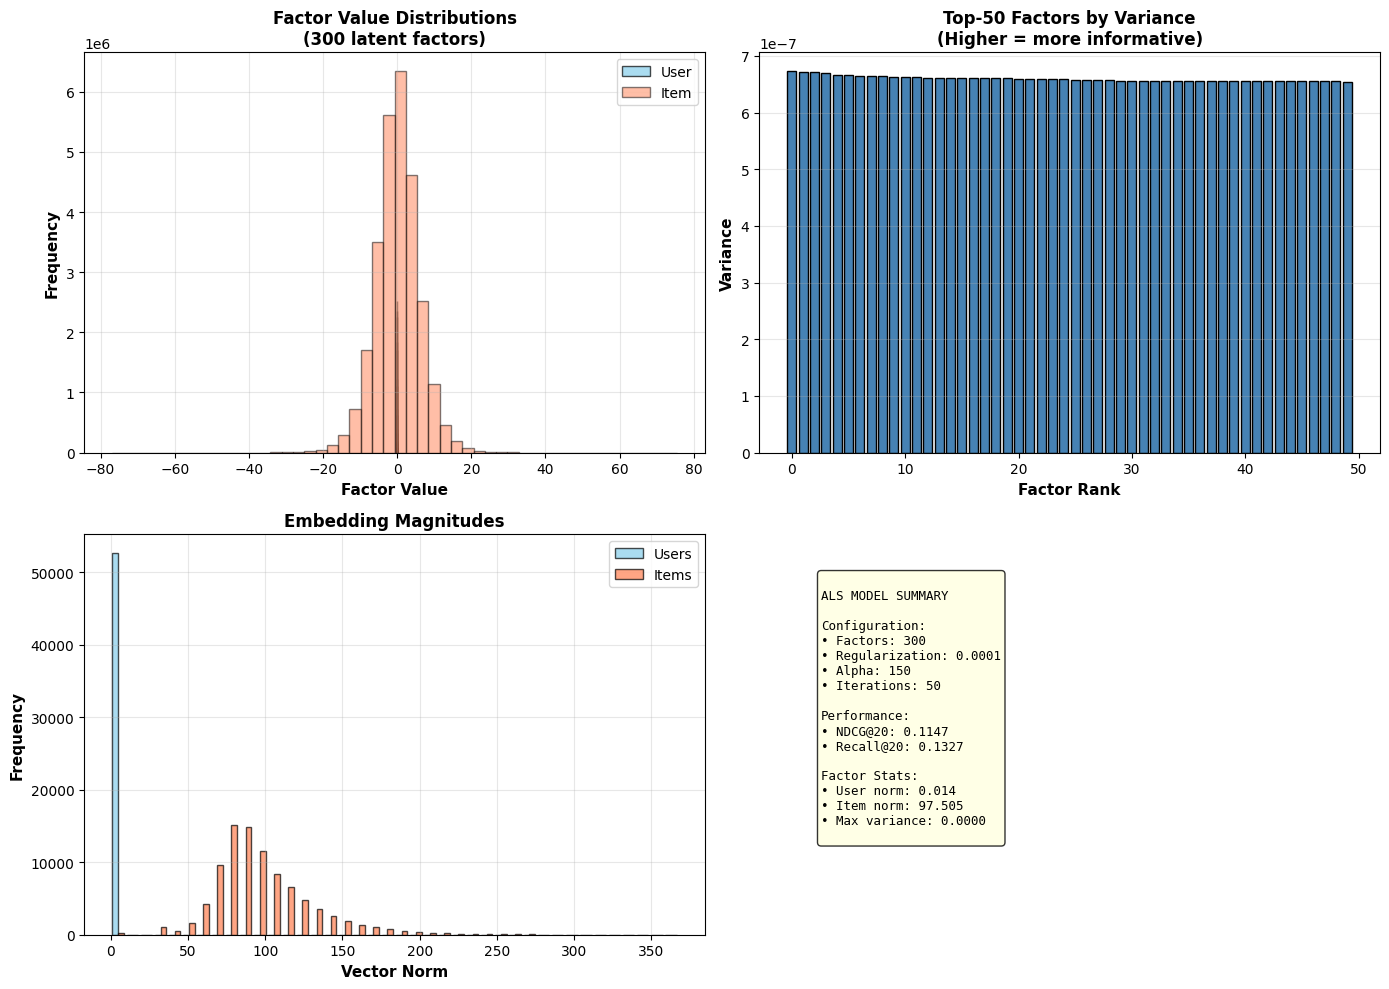


 Saved: als_factor_analysis.png


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("VISUALIZATION: FACTOR ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Factor distributions
axes[0, 0].hist(user_factors.flatten(), bins=50, color='skyblue',
               edgecolor='black', alpha=0.7, label='User')
axes[0, 0].hist(item_factors.flatten(), bins=50, color='coral',
               edgecolor='black', alpha=0.5, label='Item')
axes[0, 0].set_xlabel('Factor Value', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Factor Value Distributions\n(300 latent factors)',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Factor variance (importance)
user_var = np.var(user_factors, axis=0)
top_factors = sorted(user_var, reverse=True)[:50]

axes[0, 1].bar(range(len(top_factors)), top_factors, color='steelblue', edgecolor='black')
axes[0, 1].set_xlabel('Factor Rank', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Variance', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Top-50 Factors by Variance\n(Higher = more informative)',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Embedding norms
user_norms = np.linalg.norm(user_factors, axis=1)
item_norms = np.linalg.norm(item_factors, axis=1)

axes[1, 0].hist([user_norms, item_norms], bins=40, label=['Users', 'Items'],
               color=['skyblue', 'coral'], alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Vector Norm', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Embedding Magnitudes', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Model summary
summary = f"""
ALS MODEL SUMMARY

Configuration:
• Factors: 300
• Regularization: 0.0001
• Alpha: 150
• Iterations: 50

Performance:
• NDCG@20: {np.mean(ndcg_scores_full):.4f}
• Recall@20: {np.mean(recall_scores):.4f}

Factor Stats:
• User norm: {user_norms.mean():.3f}
• Item norm: {item_norms.mean():.3f}
• Max variance: {user_var.max():.4f}
"""

axes[1, 1].text(0.1, 0.9, summary, transform=axes[1, 1].transAxes,
               fontsize=9, verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('als_factor_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: als_factor_analysis.png")


#Step 14 : Evaluation Mertics

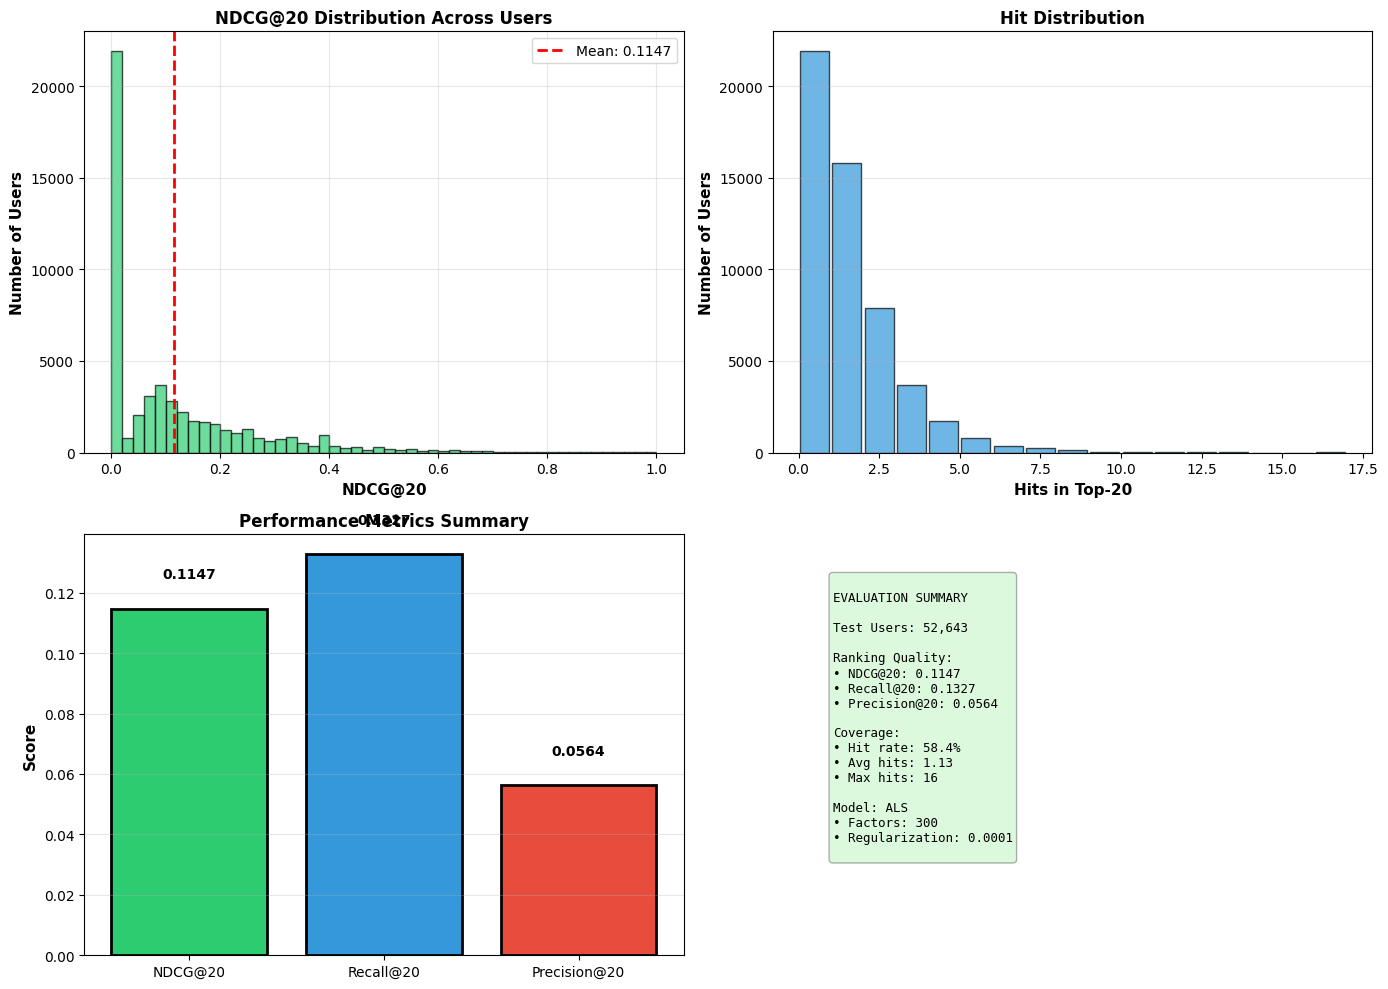


 Saved: als_evaluation_metrics.png


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. NDCG distribution
axes[0, 0].hist(ndcg_scores_full, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(ndcg_scores_full), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(ndcg_scores_full):.4f}')
axes[0, 0].set_xlabel('NDCG@20', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Users', fontsize=11, fontweight='bold')
axes[0, 0].set_title('NDCG@20 Distribution Across Users', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Hit distribution
axes[0, 1].hist(hit_counts_full, bins=range(0, max(hit_counts_full)+2),
               color='#3498db', edgecolor='black', alpha=0.7, rwidth=0.9)
axes[0, 1].set_xlabel('Hits in Top-20', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Users', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Hit Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Metrics bar chart
metrics = ['NDCG@20', 'Recall@20', 'Precision@20']
values = [np.mean(ndcg_scores_full), np.mean(recall_scores), np.mean(precision_scores)]
colors_m = ['#2ecc71', '#3498db', '#e74c3c']

bars = axes[1, 0].bar(metrics, values, color=colors_m, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Performance Metrics Summary', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., val + 0.01,
                   f'{val:.4f}', ha='center', fontsize=10, fontweight='bold')

# 4. Summary
eval_summary = f"""
EVALUATION SUMMARY

Test Users: {len(test_dict):,}

Ranking Quality:
• NDCG@20: {np.mean(ndcg_scores_full):.4f}
• Recall@20: {np.mean(recall_scores):.4f}
• Precision@20: {np.mean(precision_scores):.4f}

Coverage:
• Hit rate: {100*users_with_hits/len(hit_counts_full):.1f}%
• Avg hits: {np.mean(hit_counts_full):.2f}
• Max hits: {max(hit_counts_full)}

Model: ALS
• Factors: 300
• Regularization: 0.0001
"""

axes[1, 1].text(0.1, 0.9, eval_summary, transform=axes[1, 1].transAxes,
               fontsize=9, verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('als_evaluation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: als_evaluation_metrics.png")
